In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


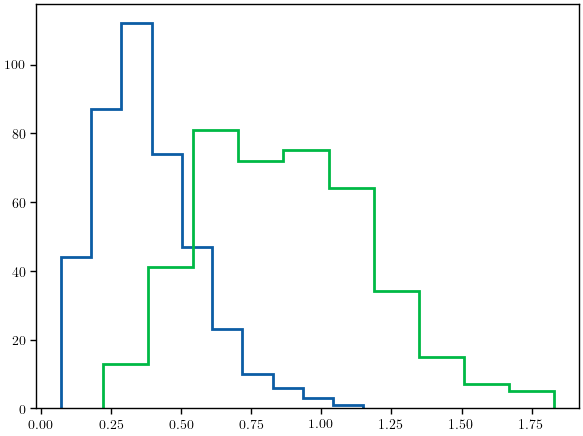

In [5]:
high_snr_lenses = [l for l in detectable_lenses if l.snr > 115.47 and l.snr != np.inf]

plt.hist([l.z_lens for l in high_snr_lenses], histtype='step', lw=2)
plt.hist([l.z_source for l in high_snr_lenses], histtype='step', lw=2)
plt.show()

In [5]:
snrs = [l.snr for l in detectable_lenses if l.snr != np.inf]

In [6]:
# Create a histogram from the snrs list using numpy
hist, bin_edges = np.histogram(snrs, bins=50)

# Print the histogram and bin edges
print("Histogram:", hist)
print("Bin edges:", bin_edges)

Histogram: [5789 2778 1539 1833 1473  867  622  408  261  176  101   82   62   56
   39   27   17   15    9   17    3    6    6    6    6    2    4    1
    0    0    2    1    2    1    0    0    1    0    0    0    0    0
    1    0    0    0    0    0    0    1]
Bin edges: [ 20.00046   29.088873  38.177288  47.2657    56.354115  65.44253
  74.530945  83.619354  92.70777  101.79618  110.8846   119.97301
 129.06142  138.14984  147.23825  156.32666  165.41508  174.5035
 183.5919   192.68031  201.76874  210.85715  219.94556  229.03398
 238.12239  247.2108   256.29922  265.38763  274.47604  283.56445
 292.65286  301.74127  310.8297   319.91812  329.00653  338.09494
 347.18335  356.27176  365.36017  374.44858  383.53702  392.62543
 401.71384  410.80225  419.89066  428.97906  438.06747  447.1559
 456.24432  465.33273  474.42114 ]


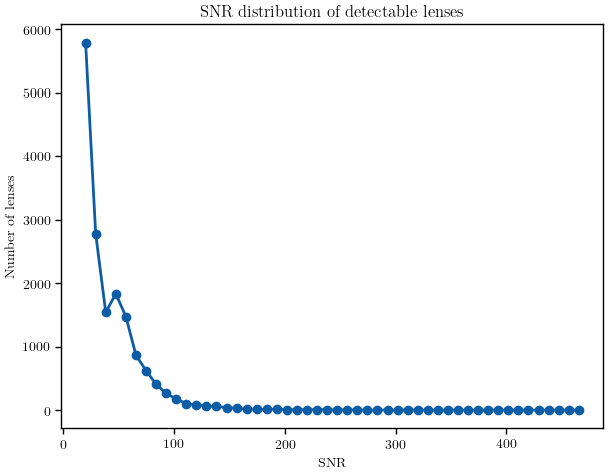

In [7]:
plt.plot(bin_edges[:-1], hist, linestyle='-', marker='o')
plt.xlabel('SNR')
plt.ylabel('Number of lenses')
plt.title('SNR distribution of detectable lenses')
plt.show()

Optimal parameters: [1.40038938e+04 4.85376040e-02 2.68498853e+01]
Covariance of parameters: [[1.24398026e+06 3.03382097e+00 6.41686662e+03]
 [3.03382097e+00 8.52776424e-06 2.78688221e-02]
 [6.41686662e+03 2.78688221e-02 8.97325551e+02]]


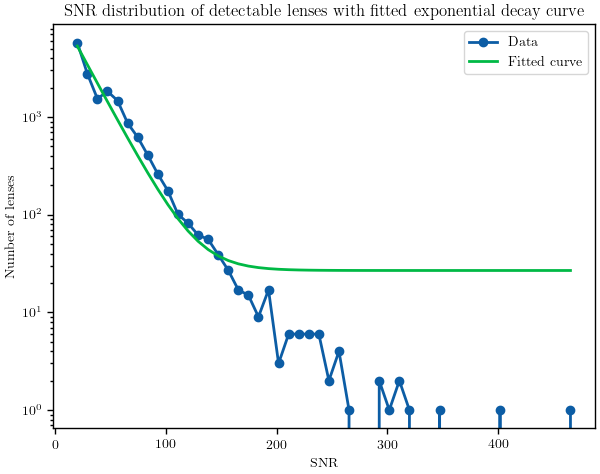

In [8]:
from scipy.optimize import curve_fit


# Define the exponential decay function
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


# Fit the exponential decay curve to the histogram data
popt, pcov = curve_fit(exponential_decay, bin_edges[:-1], hist, p0=(1, 1e-6, 1))

# Print the optimal parameters
print("Optimal parameters:", popt)
print("Covariance of parameters:", pcov)

# Plot the histogram and the fitted curve
plt.plot(bin_edges[:-1], hist, linestyle='-', marker='o', label='Data')
plt.plot(bin_edges[:-1], exponential_decay(bin_edges[:-1], *popt), label='Fitted curve')
plt.xlabel('SNR')
plt.ylabel('Number of lenses')
plt.title('SNR distribution of detectable lenses with fitted exponential decay curve')
plt.legend()
plt.yscale('log')
plt.show()

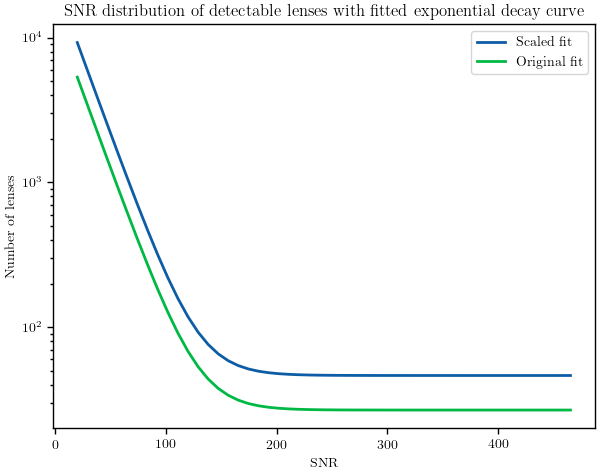

In [9]:
plt.plot(bin_edges[:-1], np.sqrt(3) * exponential_decay(bin_edges[:-1], *popt), label='Scaled fit')
plt.plot(bin_edges[:-1], exponential_decay(bin_edges[:-1], *popt), label='Original fit')
plt.xlabel('SNR')
plt.ylabel('Number of lenses')
plt.title('SNR distribution of detectable lenses with fitted exponential decay curve')
plt.legend()
plt.yscale('log')
plt.show()

In [10]:
from scipy.integrate import quad


# Define the function to integrate
def integrand(x):
    return np.sqrt(4) * exponential_decay(x, *popt)


# Perform the integration from 20 to infinity
result, error = quad(integrand, 20, np.inf)

# Print the result and the error
print("Integral result:", result)
print("Integration error:", error)

Integral result: 218525.18143424392
Integration error: 3.097986336797476e-06


In [11]:
# Perform the integration from 200 to infinity
result_200, error_200 = quad(integrand, 200, np.inf)

# Print the result and the error
print("Integral result from 200 to infinity:", result_200)
print("Integration error from 200 to infinity:", error_200)

Integral result from 200 to infinity: -18.6021436303854
Integration error from 200 to infinity: 7.034454796439604e-08


that's definitely inaccurate because of insufficient samples at higher SNRs

In [12]:
# Define the function to integrate using histogram data
def hist_integrand(x):
    bin_index = np.digitize(x, bin_edges) - 1
    if bin_index >= len(hist):
        return 0
    return np.sqrt(4) * hist[bin_index]


# Perform the integration from 200 to infinity
hist_result_200, hist_error_200 = quad(hist_integrand, 200, np.inf)

# Print the result and the error
print("Integral result from 200 to infinity using histogram data:", hist_result_200)
print("Integration error from 200 to infinity using histogram data:", hist_error_200)

Integral result from 200 to infinity using histogram data: 835.7880936258899
Integration error from 200 to infinity using histogram data: 44.111009747408275
